In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.signal import find_peaks

In [2]:
# --- Parameters ---
L = 1.0         # Longitud de la cuerda/círculo
c = 1.0         # Velocidad de la onda
T = 20.0       # Duración de la simulación
dx = 0.01       # Paso espacial
dt = 0.005      # Paso temporal
N = int(L/dx)   # Número de puntos espaciales
M = int(T/dt)   # Número de puntos temporales

In [3]:
# --- Funciones ---
def gaussian_pulse(x, A, x_0, sigma):
    """Genera un pulso Gaussiano."""
    return A * np.exp(-0.5 * ((x - x_0) / sigma) ** 2)

def f(n, x):
    """Función para condiciones iniciales basadas en senos."""
    return np.sin(n * x)

In [4]:
# --- Configuración de la simulación ---
theta = np.linspace(0, 2 * np.pi, N)  # Coordenada angular (para el círculo)
gamma = c * dt / dx                   # Factor de Courant-Friedrichs-Lewy

u = np.zeros((M,N)) # Create a 2D array to store the solution


In [5]:
# --- Initial spatial configuration.
theta_0 = 180 * np.pi/180
A = 0.2

u[0,:] = gaussian_pulse(theta, A, np.pi/2, 0.2) 
u[1, :] = gaussian_pulse(theta, A, np.pi/2, 0.2)

# --- Set initial conditions for ends. --- 
u[0, 0] = 0
u[-1, 0] = 0

boundary = 0
beta  = 0 #Dissipation factor (NO FUNCIONA.).


In [6]:
# --- Set the boundary conditions
if boundary == 1:
    u[:,0] = 0
    u[:,-1] = 0

In [7]:
# --- Esquema de diferencias finitas ---.
if beta == 0:
    for m in range(1, M - 1):
        for n in range(1, N - 1):
            u[m + 1, n] = (
                gamma**2 * (u[m, n + 1] + u[m, n - 1])
                + 2 * (1 - gamma**2) * u[m, n]
                - u[m - 1, n]
            )

            if boundary == 0:
                u[m+1, 0] = u[m + 1, 1] # Slope 0 in theta_0 condition.
                u[m+1, -1] = u[m+1, 0] #Continuity condition.
                u[m + 1, -2] = u[m+1, 1] #Evita picos.

else: 

    for m in range(1, M - 1):
        for n in range(1, N - 1):
            u[m + 1, n] = 1 / (1 + beta*dt)*( gamma**2 * (u[m, n + 1] + u[m, n - 1])
                + 2 * (1 - gamma**2) * u[m, n]
                - u[m - 1, n] + 2*beta*dt*u[m,n])

            if boundary == 0:
                u[m+1, 0] = u[m + 1, 1] # Slope 0 in theta_0 condition.
                u[m+1, -1] = u[m+1, 0] #Continuity condition.
                u[m + 1, -2] = u[m+1, 1] #Evita picos.


In [8]:
amplitudes=[]
frecuencias=[]
def modes(angulo):
    pto = int(5*angulo/18)
    fig, axs = plt.subplots(3,2, figsize=(15, 15))
    fig.suptitle("Frecuencias teóricas la taza sin  asa", fontsize=25)
    
      
    for idx, i in enumerate([0, 60, 120, 180, 240, 300]):
        
        # --- Initial spatial configuration.
        
        theta_0 = 180 * np.pi/180

        theta_pulse = i * np.pi/180
        u[0,:] = gaussian_pulse(theta, 0.4, theta_pulse, 0.2) 
        u[1, :] = gaussian_pulse(theta, 0.4, theta_pulse, 0.2)
        
        # --- Set the boundary conditions
        u[:,0] = 0  #all time, first point is a node 
        u[:,-1] = 0 #all time, last point is a node
        
                # --- Esquema de diferencias finitas ---
        if beta == 0:
            for m in range(1, M - 1):
                for n in range(1, N - 1):
                    u[m + 1, n] = (
                        gamma**2 * (u[m, n + 1] + u[m, n - 1])
                        + 2 * (1 - gamma**2) * u[m, n]
                        - u[m - 1, n]
                    )

                    if boundary == 0:
                        u[m+1, 0] = u[m + 1, 1] # Slope 0 in theta_0 condition.
                        u[m+1, -1] = u[m+1, 0] #Continuity condition.
                        u[m + 1, -2] = u[m+1, 1] #Evita picos.

        else: 

            for m in range(1, M - 1):
                for n in range(1, N - 1):
                    u[m + 1, n] = 1 / (1 + beta*dt)*( gamma**2 * (u[m, n + 1] + u[m, n - 1])
                        + 2 * (1 - gamma**2) * u[m, n]
                        - u[m - 1, n] + 2*beta*dt*u[m,n])

                    if boundary == 0:
                        u[m+1, 0] = u[m + 1, 1] # Slope 0 in theta_0 condition.
                        u[m+1, -1] = u[m+1, 0] #Continuity condition.
                        u[m + 1, -2] = u[m+1, 1] #Evita picos.

        
        fft_result = np.fft.fft(u[:,pto])
        fft_freq = np.fft.fftfreq(M, dt)

        magnitude = np.abs(fft_result)

        # Filtrar frecuencias negativas
        positive_freqs = fft_freq > 0
        fft_freq = fft_freq[positive_freqs]
        magnitude = magnitude[positive_freqs]
        amplitudes.append(magnitude)
        frecuencias.append(fft_freq)

        #Identificar la frecuencia dominante
        dominant_freq = fft_freq[np.argmax(magnitude)]

        print(f"La frecuencia dominante es: {dominant_freq} Hz")
        
        

        row = idx // 2
        col = idx % 2
        
        axs[row, col].plot(fft_freq, magnitude)
        axs[row, col].set_title(f"θ = {i}°",fontsize=17)
        axs[row, col].set_xlabel("Frecuencia [Hz]",fontsize=17)
        axs[row, col].set_ylabel("Magnitud",fontsize=17)
        axs[row, col].set_xscale('log')  
        axs[row, col].grid(True)
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

La frecuencia dominante es: 0.05 Hz
La frecuencia dominante es: 2.0500000000000003 Hz
La frecuencia dominante es: 2.0500000000000003 Hz
La frecuencia dominante es: 2.0500000000000003 Hz
La frecuencia dominante es: 2.0500000000000003 Hz
La frecuencia dominante es: 2.0500000000000003 Hz


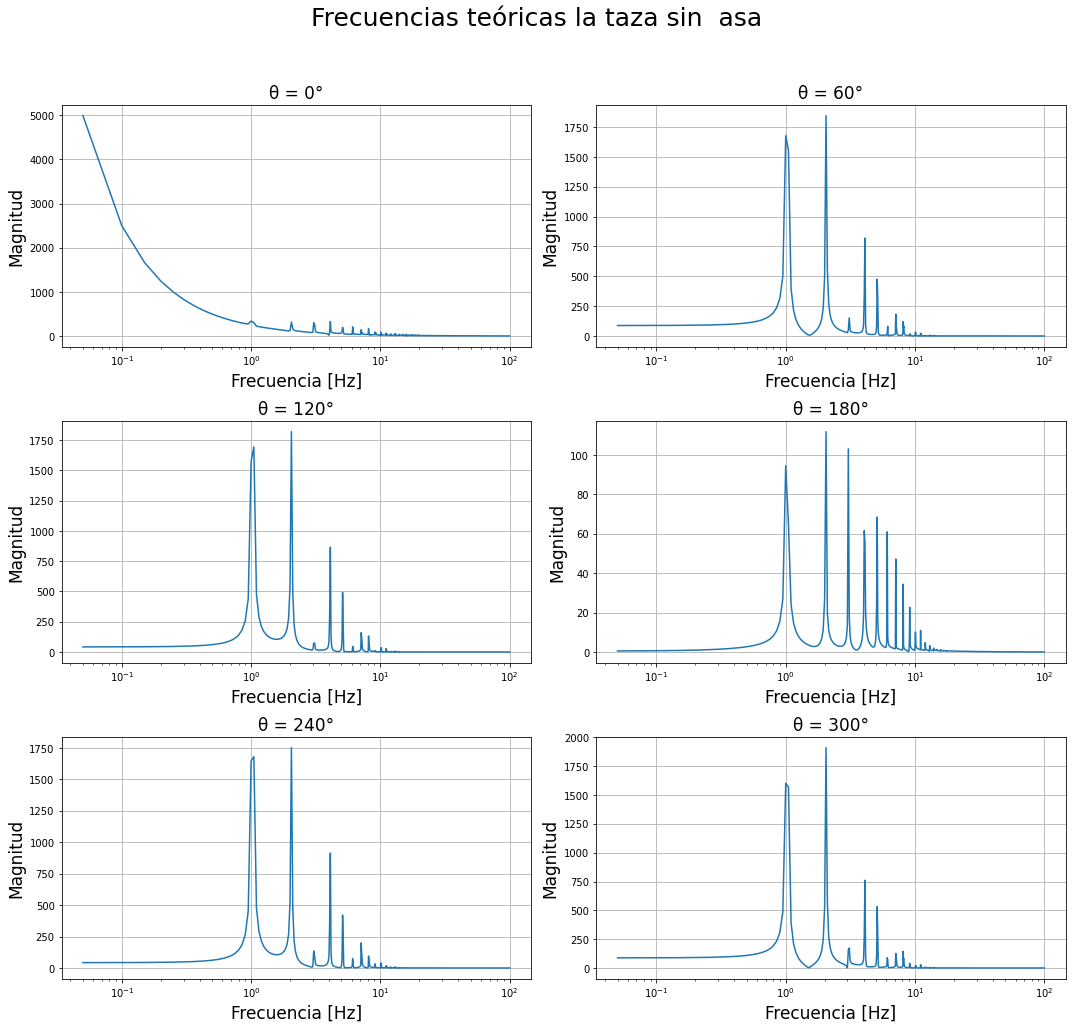

In [9]:
modes(180)

In [10]:
peaks = []
for i in range(6):
    picos, _ = find_peaks(amplitudes[i])
    peaks.append(picos)

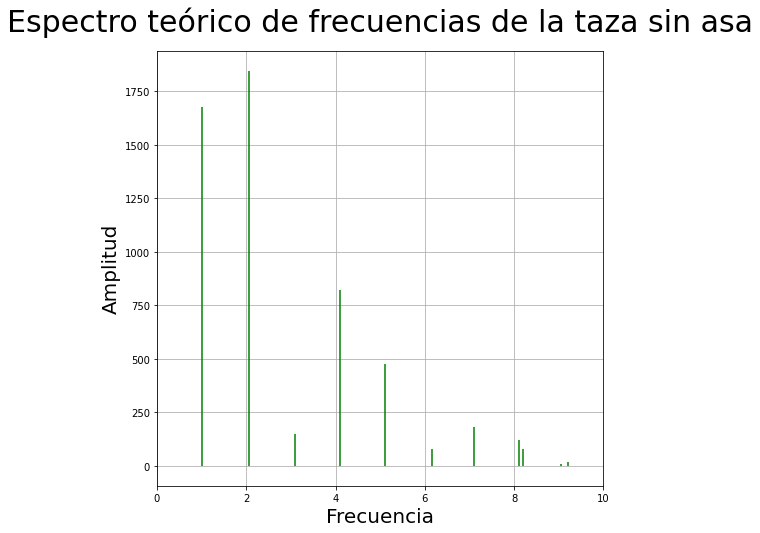

In [12]:
plt.figure(figsize=(8,8))

plt.vlines(frecuencias[1][peaks[1]], 0, amplitudes[1][peaks[1]], color='green', linestyle='-')


plt.xlabel('Frecuencia', fontsize=20)
plt.ylabel('Amplitud', fontsize=20)
plt.title('Espectro teórico de frecuencias de la taza sin asa', fontsize=30,pad=20)
plt.xlim(0, 10)

plt.grid()
plt.show()